# Analyse des données et prétraitement

In [238]:
import os
import librosa as lr
from IPython.display import Audio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Regroupement des données

In [239]:

# Chemins vers les répertoires et fichiers
data_dir = "data/audio_and_txt_files"
diagnosis_file = "data/patient_diagnosis.csv"
demographics_file = "data/demographic_info.txt"

# Charger le fichier des diagnostics
diagnosis_df = pd.read_csv(diagnosis_file, header=None, names=["patient", "diagnosis"])

# Charger le fichier des informations démographiques
demographics_df = pd.read_csv(
    demographics_file,
    sep=r'\s+', # Utiliser détection d'espaces multiples comme séparateur
    header=None,
    names=["patient", "age", "sex", "adult_bmi", "child_weight", "child_height"],
    na_values=["NA"]  # Gérer NA comme valeur manquante
)

# Initialisation de la liste pour stocker les données
data = []

# Parcourir les fichiers audio et texte
for filename in os.listdir(data_dir):
    if filename.endswith(".wav"):  # Fichiers audio
        # Extraire les métadonnées à partir du nom de fichier
        parts = filename.split("_")
        patient = int(parts[0])
        recording_index = parts[1]
        chest_location = parts[2]
        acquisition_mode = parts[3]
        recording_equipment = parts[4].split(".")[0]
        
        # Associer le diagnostic
        diagnosis = diagnosis_df.loc[diagnosis_df["patient"] == patient, "diagnosis"]
        diagnosis = diagnosis.iloc[0] if not diagnosis.empty else "Unknown"

        # Associer les informations démographiques
        demographics = demographics_df.loc[demographics_df["patient"] == patient]
        if not demographics.empty:
            age = demographics["age"].iloc[0]
            sex = demographics["sex"].iloc[0]
            adult_bmi = demographics["adult_bmi"].iloc[0]
            child_weight = demographics["child_weight"].iloc[0]
            child_height = demographics["child_height"].iloc[0]
        else:
            age, sex, adult_bmi, child_weight, child_height = None, None, None, None, None

        # Charger le fichier texte correspondant
        txt_filename = filename.replace(".wav", ".txt")
        txt_filepath = os.path.join(data_dir, txt_filename)
        
        if os.path.exists(txt_filepath):
            with open(txt_filepath, "r") as file:
                for line in file:
                    begin_time, end_time, crackles, wheezes = map(float, line.strip().split("\t"))
                    data.append({
                        "patient": patient,
                        "recording_index": recording_index,
                        "chest_location": chest_location,
                        "acquisition_mode": acquisition_mode,
                        "recording_equipment": recording_equipment,
                        "diagnosis": diagnosis,
                        "age": age,
                        "sex": sex,
                        "adult_bmi": adult_bmi,
                        "child_weight": child_weight,
                        "child_height": child_height,
                        "begin_time": begin_time,
                        "end_time": end_time,
                        "crackles": int(crackles),
                        "wheezes": int(wheezes),
                    })

# Créer un DataFrame à partir des données
df = pd.DataFrame(data)

# Sauvegarder dans un fichier CSV
df.to_csv("data/processed_data.csv", index=False)


## Analyse des données

### Aperçu des données CSV

In [240]:
# Dimensions des données
print("Dimensions du DataFrame :", df.shape)

# Résumé des colonnes
print("\nRésumé des colonnes :")
print(df.info())

# Aperçu des données
print("\nAperçu des premières lignes :")
print(df.head())

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe(include='all'))

Dimensions du DataFrame : (6898, 15)

Résumé des colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              6898 non-null   int64  
 1   recording_index      6898 non-null   object 
 2   chest_location       6898 non-null   object 
 3   acquisition_mode     6898 non-null   object 
 4   recording_equipment  6898 non-null   object 
 5   diagnosis            6898 non-null   object 
 6   age                  6837 non-null   float64
 7   sex                  6837 non-null   object 
 8   adult_bmi            6004 non-null   float64
 9   child_weight         749 non-null    float64
 10  child_height         726 non-null    float64
 11  begin_time           6898 non-null   float64
 12  end_time             6898 non-null   float64
 13  crackles             6898 non-null   int64  
 14  wheezes              6898 no

Les données semnblent cohérentes, mais il est difficile de les vérifier sans plus d'informations.

### Vérifier les valeurs manquantes CSV

In [241]:
missing_values = df.isnull().sum()
print("\nValeurs manquantes par colonne :")
print(missing_values)


Valeurs manquantes par colonne :
patient                   0
recording_index           0
chest_location            0
acquisition_mode          0
recording_equipment       0
diagnosis                 0
age                      61
sex                      61
adult_bmi               894
child_weight           6149
child_height           6172
begin_time                0
end_time                  0
crackles                  0
wheezes                   0
dtype: int64


### Visualisation initiale CSV

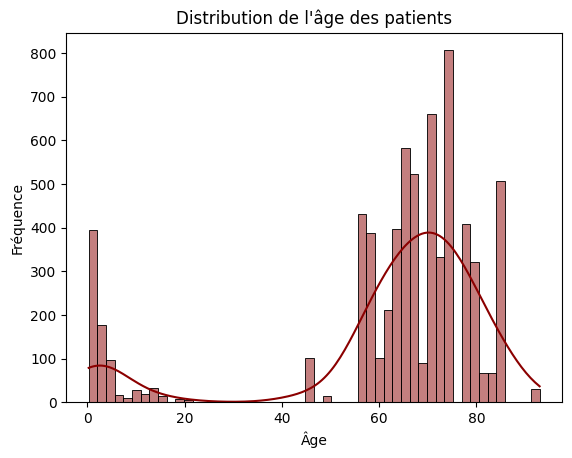

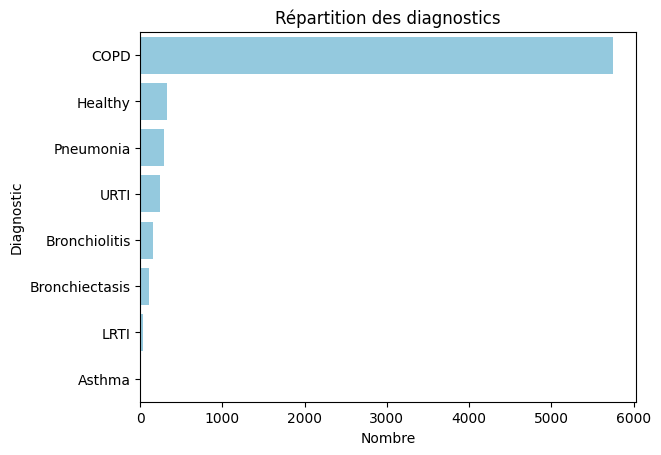

In [242]:
# Distribution de l'âge
sns.histplot(
    df["age"],
    kde=True,
    kde_kws={"bw_adjust": 1.5},
    color="darkred",
)
plt.title("Distribution de l'âge des patients")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

# Nombre de diagnostics par catégorie
sns.countplot(y="diagnosis", data=df, order=df["diagnosis"].value_counts().index, color="skyblue")
plt.title("Répartition des diagnostics")
plt.xlabel("Nombre")
plt.ylabel("Diagnostic")
plt.show()

### Suppression des valeurs abbérantes CSV

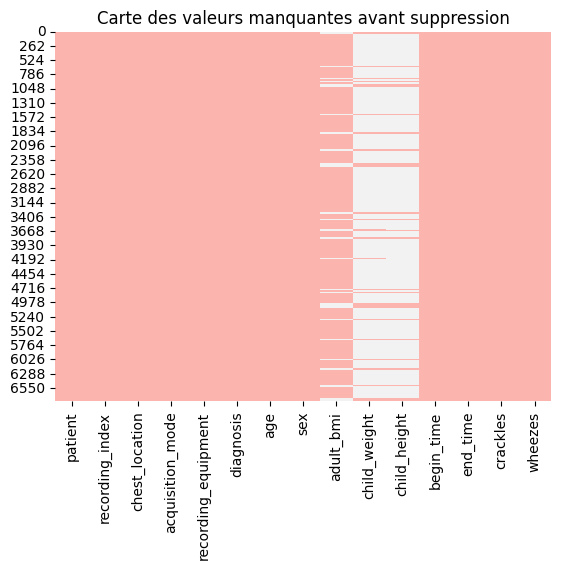

patient                   0
recording_index           0
chest_location            0
acquisition_mode          0
recording_equipment       0
diagnosis                 0
age                       0
sex                       0
adult_bmi               788
child_weight           6043
child_height           6066
begin_time                0
end_time                  0
crackles                  0
wheezes                   0
dtype: int64


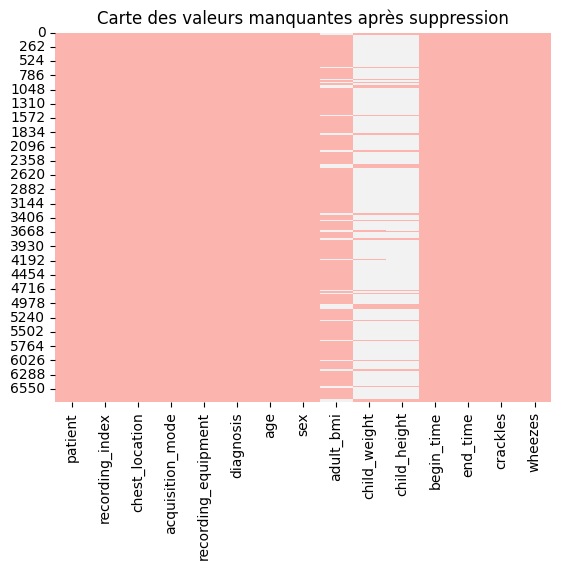

In [245]:
# # Suppression des valeurs aberrantes pour l'âge (ici pas besoin car on a pas de valeurs aberrantes sur l'âge)
# # df = df[(df["age"] > 0) & (df["age"] < 120)]

# Afficher la carte des valeurs manquantes avant suppression
sns.heatmap(df.isnull(), cbar=False, cmap="Pastel1")
plt.title("Carte des valeurs manquantes avant suppression")
plt.show()

# Suppression des 2 patients qui n'ont pas d'âge, de sexe
df.dropna(subset=["age", "sex"], inplace=True)

# Suppresion des patients adultes qui nont pas de BMI
df = df[~((df["age"] >= 18) & df["adult_bmi"].isna())]

# Vérifier s'il reste des valeurs manquantes
print(df.isnull().sum())

# Afficher la carte des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False, cmap="Pastel1")
plt.title("Carte des valeurs manquantes après suppression")
plt.show()

On remarque que les valeurs manquantes sont principalement dans les colonnes child_weight et child_height. Ce qui est cohérent puisque la plupart des patients sont des adultes.

Également on supprime les patients qui n'ont pas d'âge ou de sexe pour éviter de fausser les résultats.

## Nettoyage des données Audio

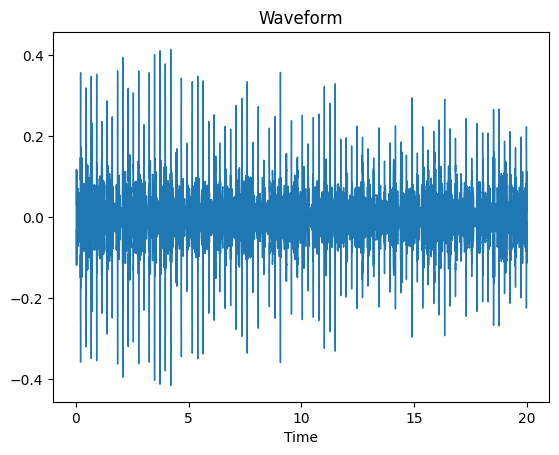

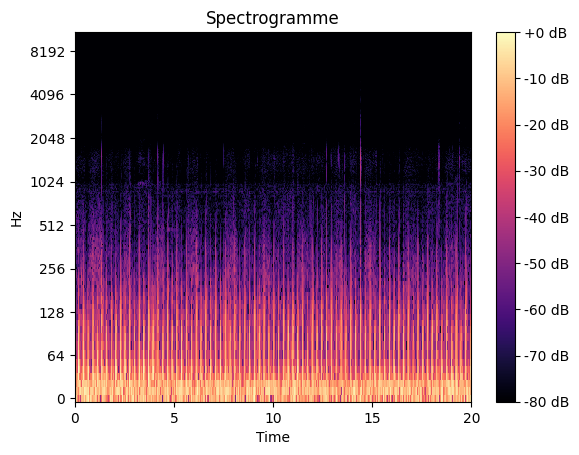

In [244]:
# Récupérer que les fichiers audio
audio_files = [f for f in os.listdir("data/audio_and_txt_files") if f.endswith(".wav")]


# Charger un fichier audio
audio, sr = lr.load("data/audio_and_txt_files/" + audio_files[0])

# Afficher le signal audio
lr.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.show()

# Afficher le spectogramme
lr.display.specshow(lr.amplitude_to_db(np.abs(lr.stft(audio)), ref=np.max), y_axis='log', x_axis='time')
plt.title("Spectrogramme")
plt.colorbar(format='%+2.0f dB')
plt.show()

# Afficher l'audio
Audio(data=audio, rate=sr)